[View in Colaboratory](https://colab.research.google.com/github/tjdahlke/satellite_imagery_analysis/blob/master/image_processing_walk_through.ipynb)

# Hyperspectral image analysis walk-through

---
## Hyperspectral what??
Planet (the company) has a good deal of **analytical** imagery available to access through it's API. Analytical means that it isn't just plain RGB images (like the pictures your cell phone takes), but is hyperspectral instead. **Hyperspectral** imagery includes capture of frequency bands that cant be seen with the naked eye, like the NIR band (Near InfraRed). In this notebook I'll walkthrough all steps from identifying an area of interest (AOI), to loading the image into a numpy array (easy place to start other analysis), to plotting the different frequency bands for interpretation. 

Make sure you have:

*   Python 3
*   A Planet API key (if you dont have an account/API key, sign up [here](https://www.planet.com/explorer/?signup=535muk17m5))

---





## Setup your API key

In [23]:
# Set this with your own Planet API key. 
PLANET_API_KEY='yourPlanetAPIKeyHere'
!echo $PLANET_API_KEY

yourPlanetAPIKeyHere


## Setup environment


In [12]:
!pip install tqdm
!mkdir -p output
!ls

datalab  output


## Choose an Area of Interest (AOI)
This is the fun part. Select your own AOI [here](http://geojson.io/#map=2/20.0/0.0) and then copy/paste the .json info into this notebook. Of course you can use the example below which is of a small farm in Brentwood CA.

**NOTE**: If you have a free Planet account, then your API key will only let you download imagery from California at this time

In [0]:
# Some farm in Brentwood area. AOI size about the same as a well pad
geojson_geometry={
        "type": "Polygon",
        "coordinates": [
          [
            [
              -121.67504310607909,
              37.89233101674256
            ],
            [
              -121.67195320129395,
              37.89233101674256
            ],
            [
              -121.67195320129395,
              37.89443076208804
            ],
            [
              -121.67504310607909,
              37.89443076208804
            ],
            [
              -121.67504310607909,
              37.89233101674256
            ]
          ]
        ]
      }


## Create Filters

Now let's set up some **filters** to further constrain our Data API search. Here we choose to select imagery within a certain date range, and with little cloud cover to interfere. 

In [0]:
# Get images that overlap with our AOI 
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geojson_geometry
}

# Get images acquired within a date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "2011-08-31T00:00:00.000Z",
    "lte": "2018-02-01T00:00:00.000Z"
  }
}

# Only get images which have <10% cloud coverage
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.1
  }
}


# Combine our geo, date, cloud filters
combined_filter = {
  "type": "AndFilter",
  "config": [geometry_filter,cloud_cover_filter,date_range_filter]
}

## Searching and Clipping the data
Now we send a post request via the API to retrieve the results of all images that fall within our filter criteria.


In [15]:
import os
import json
import requests
from requests.auth import HTTPBasicAuth

# API request object
search_request = {
    "interval": "day",
    "item_types": ["PSScene4Band"],
    "filter": combined_filter
}

# fire off the POST request
search_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PLANET_API_KEY, ''),
    json=search_request)

print(json.dumps(search_result.json(), indent=2)[0:3500][:])

{
  "_links": {
    "_first": "https://api.planet.com/data/v1/searches/aff766e1859e46e6ad53650d5e563cd9/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9kZXNjIjogdHJ1ZX0%3D",
    "_next": "https://api.planet.com/data/v1/searches/aff766e1859e46e6ad53650d5e563cd9/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6ICIyMDE2LTA5LTE0VDE5OjAyOjI3LjAwMDAwMFoiLCAic29ydF9sYXN0X2lkIjogIjIwMTYwODMxXzE4MDIzN18wZTBlIiwgInNvcnRfZGVzYyI6IHRydWV9",
    "_self": "https://api.planet.com/data/v1/searches/aff766e1859e46e6ad53650d5e563cd9/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9kZXNjIjogdHJ1ZX0%3D"
  },
  "features": [
    {
      "_l

Our search returns metadata for all of the images within our AOI that match our date range and cloud coverage filters. It looks like there are multiple images here; let's extract a list of just the image IDs:

In [16]:
# extract image IDs only
image_ids = [feature['id'] for feature in search_result.json()['features']]
item_typeList = [feature['properties']['item_type'] for feature in search_result.json()['features']]

print(image_ids)

['20180128_181615_1040', '20180121_181515_1035', '20180120_181551_103b', '20171228_181501_1042', '20171220_181435_0f34', '20171220_181434_0f34', '20171217_181354_0f22', '20171216_181428_103b', '20171216_181427_103b', '20171216_181343_0f43', '20171214_181613_0e14', '20171213_181347_1009', '20171212_181402_0f31', '20171210_181223_1015', '20171206_181402_1011', '20171205_181251_1025', '20171204_185251_0f32', '20171129_181333_0f42', '20171129_181219_0e26', '20171129_181218_0e26', '20171128_185400_0f36', '20171127_181245_1030', '20171119_181240_1013', '20171117_181248_102c', '20171106_181308_0f25', '20171101_181255_102e', '20171101_181254_102e', '20171029_181144_0f15', '20171029_181022_0f42', '20170824_190605_1054', '20171028_185724_1052', '20171028_185723_1052', '20171028_181239_0f34', '20171027_185829_104c', '20170925_190249_101c', '20170908_190429_0f3b', '20171025_181143_0f3f', '20171025_181142_0f3f', '20171025_185832_1053', '20171025_185831_1053', '20170906_190408_0f2b', '20171023_18123

Since this wont be the last time we'll try to retrieve an image from Planet, lets first build a class to organzie the tools we're going to be using a lot. We'll make this class and add a few functions that we'll use next.

In [0]:
import time
from tqdm import tqdm
import zipfile

# Define a new class and functions for image retrieval
class image_retrieval(object):
    def __init__(self, api_key):
        self.api_key=api_key
        return

    def check_assets(self,item_type,scene_id):
        # Check to see what assets exist for this item
        id0_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(item_type, scene_id)
        # Returns JSON metadata for assets in this ID. Learn more: planet.com/docs/reference/data-api/items-assets/#asset
        result = \
          requests.get(
            id0_url,
            auth=HTTPBasicAuth(self.api_key, '')
          )
        # List of asset types available for this particular satellite image
        return result.json().keys()
      
      
    def request_clip(self,item_type,scene_id,asset_type):
        # Construct clip API payload
        clip_payload = {
            'aoi': geojson_geometry,
            'targets': [
              {
                'item_id': scene_id,
                'item_type': item_type,
                'asset_type': asset_type
              }
            ]
        }
        # Request clip of scene (This will take some time to complete)
        request = requests.post('https://api.planet.com/compute/ops/clips/v1', auth=(self.api_key, ''), json=clip_payload)
        print(request.json())
        clip_url = request.json()['_links']['_self']
        # Poll API to monitor clip status. Once finished, download and upzip the scene
        clip_succeeded = False
        while not clip_succeeded:
          # Poll API
            check_state_request = requests.get(clip_url, auth=(PLANET_API_KEY, ''))
            # If clipping process succeeded , we are done
            if check_state_request.json()['state'] == 'succeeded':
                clip_download_url = check_state_request.json()['_links']['results'][0]
                clip_succeeded = True
                print("Clip of scene succeeded and is ready to download") 
            # Still activating. Wait 2 second and check again.
            else:
                print("...Still waiting for clipping to complete...")
                time.sleep(2)
        return clip_download_url

Since we just want a single image, and this is only a demonstration, for our purposes here we can arbitrarily select an image in that list. Let's do that, and get the asset list available for that image using the function we just wrote:

In [18]:
# Pick an item (say the first one)
ii=50
scene_id = image_ids[ii]
item_type=item_typeList[ii]

# Initialize image retrieval object
imgRetObj=image_retrieval(PLANET_API_KEY)
jsonList=imgRetObj.check_assets(item_type,scene_id)
print(jsonList)

dict_keys(['analytic', 'analytic_sr', 'analytic_xml', 'udm'])


## Clip and Download the chosen asset
We're interested in looking at the **analytic_sr** (surface reflectance) asset, which has all four frequency bands in it, and is adjusted for atmospheric conditions (read more about this [here](https://assets.planet.com/marketing/PDF/Planet_Surface_Reflectance_Technical_White_Paper.pdf)). We'll clip the AOI out of the asset from the seleced image ID, then "activate" it.

In [19]:
asset_type = 'analytic_sr'
clip_download_url=imgRetObj.request_clip(item_type,scene_id,asset_type)

{'_links': {'_self': 'https://api.planet.com/compute/ops/clips/v1/d69c2438-31cc-426e-97e3-57e3263e66b1', 'results': None}, 'aoi': {'coordinates': [[[-121.67504310607909, 37.89233101674256], [-121.67195320129395, 37.89233101674256], [-121.67195320129395, 37.89443076208804], [-121.67504310607909, 37.89443076208804], [-121.67504310607909, 37.89233101674256]]], 'type': 'Polygon'}, 'created_on': '2018-04-06T00:27:19.636Z', 'id': 'd69c2438-31cc-426e-97e3-57e3263e66b1', 'last_modified': '2018-04-06T00:27:19.636Z', 'state': 'running', 'targets': [{'asset_type': 'analytic_sr', 'item_id': '20171006_190128_104f', 'item_type': 'PSScene4Band'}]}
...Still waiting for clipping to complete...
...Still waiting for clipping to complete...
Clip of scene succeeded and is ready to download


Last, we download the .zip file and extract the .tif image. 

In [20]:
def download_image(clip_download_url,local_folder):
    # Download clip
    response = requests.get(clip_download_url, stream=True)
    zipname=local_folder + scene_id + '.zip'
    with open(zipname, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)
    # Extract the image file
    ziped_item = zipfile.ZipFile(zipname,'r')
    imagename=ziped_item.namelist()[0]
    outputpath=os.getcwd()+'/'+local_folder
    zf = zipfile.ZipFile(zipname)
    zf.extract(imagename,outputpath)    
    # Delete zip file
    os.remove(local_folder + scene_id + '.zip')
    imagefile=outputpath+imagename
    print('\nDownloaded clip located at: %s' %(imagefile))
    return imagefile
  
 
imagefile=download_image(clip_download_url,'output/')

66634it [00:00, 103394.60it/s]


Downloaded clip located at: /content/output/20171006_190128_104f_3B_AnalyticMS_SR_clip.tif


---
## Plotting
From here, we can load the .tif image and split it into the respective frequency band components. According to the Planet sensor documentation, these bands are:


*   Blue: **455 - 515** nm
*   Green: **500 - 590** nm
*   Red: **590 - 670** nm
*   NIR: **780 - 860** nm

Then we can plot the results! 


Reading in file /content/output/20171006_190128_104f_3B_AnalyticMS_SR_clip.tif


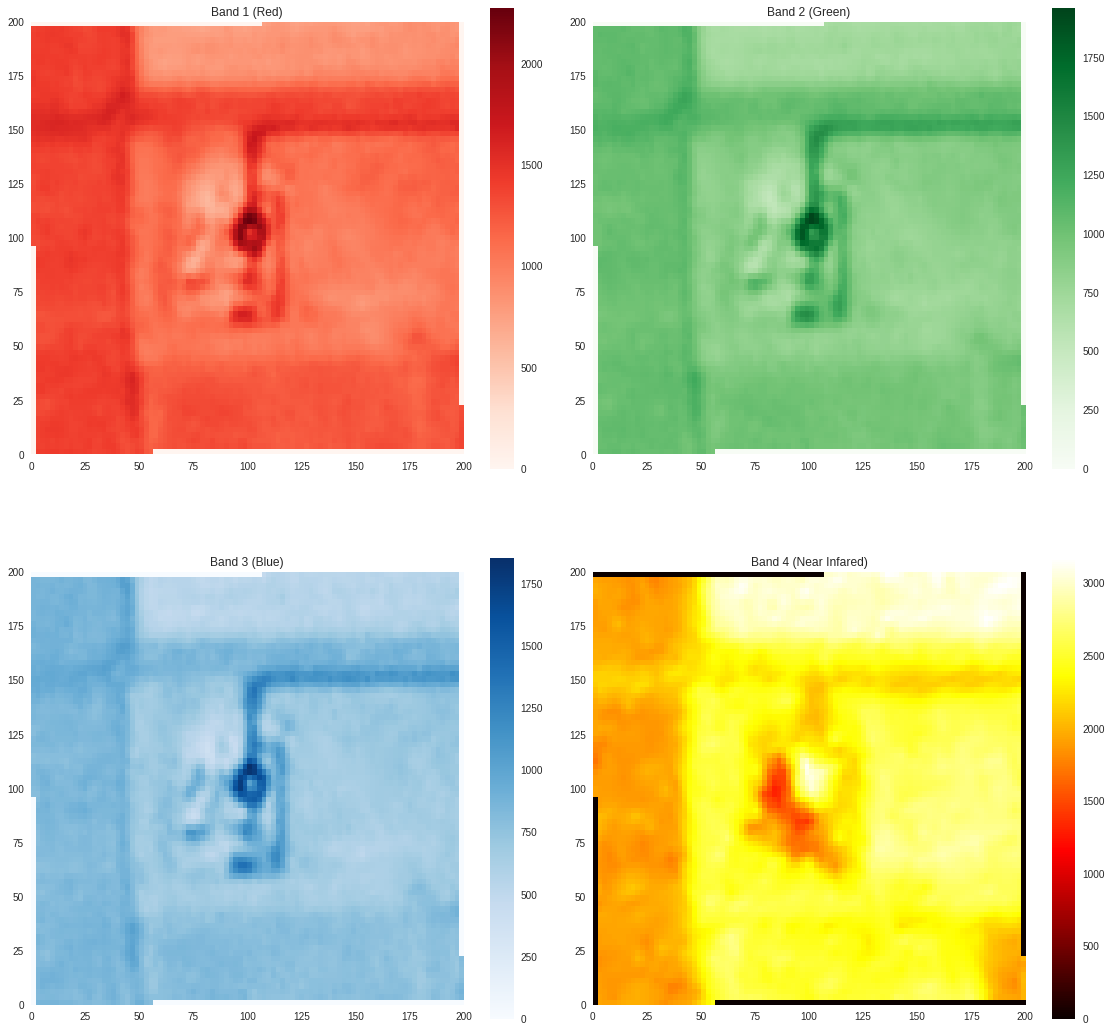

In [21]:
import cv2
import matplotlib.pyplot as plt

# Reading the downloaded image into an array
print("Reading in file %s" % (imagefile))
image = cv2.imread(imagefile, -1)
red=image[:,:,0]
green=image[:,:,1]
blue=image[:,:,2]
nir=image[:,:,3]

# Plotting the different frequency bands in the array
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

im = ax1.imshow(red, extent=[0, 200, 0, 200], cmap='Reds')
fig.colorbar(im, ax=ax1, shrink=0.8)
ax1.set_title("Band 1 (Red)")
ax1.grid(False)

im2 = ax2.imshow(green, extent=[0, 200, 0, 200], cmap='Greens')
fig.colorbar(im2, ax=ax2, shrink=0.8)
ax2.set_title("Band 2 (Green)")
ax2.grid(False)

im3 = ax3.imshow(blue, extent=[0, 200, 0, 200], cmap='Blues')
fig.colorbar(im3, ax=ax3, shrink=0.8)
ax3.set_title("Band 3 (Blue)")
ax3.grid(False)

im4 = ax4.imshow(nir, extent=[0, 200, 0, 200], cmap='hot')
fig.colorbar(im4, ax=ax4, shrink=0.8)
ax4.set_title("Band 4 (Near Infared)")
ax4.grid(False)

fig.tight_layout()


## Ok, great. But what does a "normal" image look like?
Sometimes its hard to tell what we're looking at when we analyze the bands of a hyperspectral image. So let's combine the red, green, and blue bands back into a tpyical RGB image.

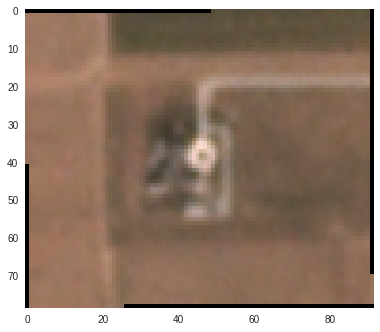

In [22]:
import numpy as np

# Stack and normalize the RGB values to 256
rgb=np.dstack((red,green,blue))
rgb=255.99*rgb/np.amax(rgb)
rgb_uint8 = (rgb) .astype(np.uint8)

# Plot the figure
plt.imshow(rgb_uint8,interpolation='nearest')
plt.grid(False)
plt.show()